In [61]:
import pyextremes as pe
from pyextremes import EVA, plot_mean_residual_life, plot_parameter_stability
import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy.optimize import minimize
from scipy import stats
#from sklearn.neighbors import KernelDensity
from scipy.integrate import quad
from statsmodels.nonparametric.kde import KDEUnivariate
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')

styles = [dict(selector="caption",
    props=[("text-align", "center"),
    ("font-size", "150%"),
    ("color", 'black')])] 

# &emsp;  &emsp;  Analýza maximálnych ročných prietokov rieky Merrimack


###  Autor: Emanuel Frátrik
###  Dátum: 16.6.2022

## 1 Úvod

V tomto protokole sa pokúsime pomocou analýzy maximalných ročných prietokov dát rieky Merrimack kvantifikovať pravdepodobnosti možných anomálnych udalostí pre rok 2022. Ak označíme $X$ náhodnú veličinu popisujúcu maximálny ročný prietok a $x$ ako množinu realizácii tejto veličiny  tak potom budeme chcieť odpovedať konkrétne na tieto otázky:
1. Aká je pravdepodobnosť, že bude v roku 2022 maximálny ročný prietok väčší ako hodnota $C=\frac{x_{(3n/4)}+x_{(3n/4 + 1)}}{2}$ ?
2. Aká je pravdepodobnosť, že bude v roku 2022 maximálny ročný prietok väčší ako hodnota $D=x_{(n)}+100$ ?
3. Aká je pravdepodobnosť, že bude v roku 2022 maximálny ročný prietok menší ako hodnota $E=\frac{x_{(4)}+x_{(5)}}{2}$ ?
4. Aká je minimálna hranica $h$ taká, že pravdepodobnosť, že maximálny ročný prietok túho hranicu prekročí je menšia než a) 0.1 b) 0.02 c) 0.04 d) 0.01 e) 0.004 ? T.j. aké budú max. prietoky pre 10-ročnú, 25, 50, 100 a 250 ročnú povodeň.
5. Aká je pravdepodobnosť, že v roku 2022 nastane horný rekord t.j. maximálny ročný prietok bude väčší ako doposiaľ zaznamenané hodnoty ?
6. Koľko je očakávaných horných rekordov v ročných maximách pre najbližších 50 rokov ?
7. Predpokladajme že rieka v roku 2022 prekročí zábranu schopnú zadržať prietok C m³/s (viď bod 1). Aká je pravdepodobnosť, že túto hodnotu $C$ prekročí o viac než $Z=\frac{x_{(n)}-x_{(3n/4)}}{2}$   m³/s ?


## 2 Prieskumová analýza dát

Nižšie vidíme dáta o priemernom mesačnom prietoku rieky `MERRIMACK RIVER` meraných stanicou `BELOW CONCORD RIVER AT LOWELL, MA`. Záznam mesačných prietokov prebiehal od roku 1923 do roku 2021. Posledná aktualizácia je z 12.11.2021. Stĺpec `YYY-MM-DD` reprezentuje dátum záznamu a stĺpec `Calculated` reprezentuje veľkosť prietoku v m³/s. Nakoľko nás zaujímajú len ročné maxima tak sa ich v nasledujúcom pokusíme extrahovať. Taktiež poznamenajme, že roky 1923 a 2021 nemajú 12 záznamov za rok. Rok 1923 som preto z analýzy vylúčil nakoľko to spôsobovalo problémy pri extrakcii blokov maxím datasetu dĺžky jeden rok.

In [11]:
data = pd.read_csv('/home/emanuel/Documents/Matematika/ModelovanieExtremUdalosti/data_month.csv', sep=';', 
                  na_values=-999., na_filter=True)
styled_data = data.iloc[np.r_[0:5, -5:0]].style.set_caption("Náhľad na dáta").set_table_styles(styles)

styled_data

,YYYY-MM-DD,hh:mm,Original,Calculated,Flag
0,1923-06-01,--:--,nan,101.044000,100
1,1923-07-01,--:--,nan,56.690000,100
2,1923-08-01,--:--,nan,51.594000,100
3,1923-09-01,--:--,nan,40.936000,100
4,1923-10-01,--:--,nan,67.793000,100
1175,2021-05-01,--:--,nan,254.961000,100
1176,2021-06-01,--:--,nan,100.496000,100
1177,2021-07-01,--:--,nan,374.193000,100
1178,2021-08-01,--:--,nan,240.538000,100
1179,2021-09-01,--:--,nan,nan,43


In [12]:
data2 = data[['YYYY-MM-DD', ' Calculated']]
data2 = data2.rename(columns={"YYYY-MM-DD": "date", " Calculated": "discharge"})
data2['year'] = pd.DatetimeIndex(data2['date']).year # vytiahnime len rok
data2 = data2.dropna() # este sa zbavme nezmyselnych hodnot
data2 = data2[8:] # get rid of year 1923

In [13]:
annual_max = data2.groupby('year', as_index=False).max()[['year', 'discharge']] # nad rokmi pouzime group_by

styled_annual_max = annual_max.iloc[np.r_[0:5, -5:0]].style.set_caption("Ročné maximá v m³/s").set_table_styles(styles)
styled_annual_max

,year,discharge
0,1924,686.494000
1,1925,478.234000
2,1926,543.871000
3,1927,500.887000
4,1928,451.842000
93,2017,627.595000
94,2018,657.139000
95,2019,629.577000
96,2020,503.001000
97,2021,374.193000


Dáta máme pripravené a môžme začať analyzovať. Celkovo máme 98 pozorovaní (pre 98 rokov). V tabuľke nižšie vidíme zhrnutie základných popisných štatistík dátového súboru. Primerný maximálny ročný prietok bol 596.82 m³/s. Maximálny ročný prietok bol pozorovaný v roku 1936 a to až 1296.31 m³/s.

In [14]:
desc = annual_max.describe()
styled_desc = desc.style.set_caption("Deskriptívne štatistiky").set_table_styles(styles)
styled_desc

,year,discharge
count,98.000000,98.000000
mean,1972.500000,596.821520
std,28.434134,181.572752
min,1924.000000,249.046000
25%,1948.250000,492.158000
50%,1972.500000,585.040500
75%,1996.750000,706.392000
max,2021.000000,1296.307000


In [15]:
ccc = annual_max.iloc[annual_max['discharge'].idxmax()]

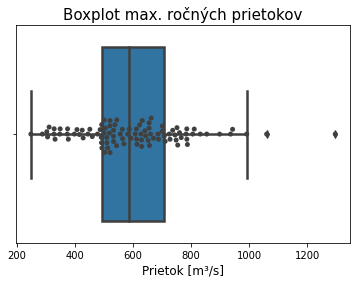

In [16]:
box = sns.boxplot(x="discharge", data=annual_max, linewidth=2.5)
box = sns.swarmplot(x="discharge",data=annual_max, color=".25")
box.set_xlabel("Prietok [m³/s]", fontsize = 12)
box.set_title('Boxplot max. ročných prietokov', fontsize = 15)
plt.show()

In [17]:
# aby sme mohli pracovat s balikom pyextremes musime data previest do pandas.Series objektu
data2['date'] = pd.to_datetime(data2['date'])
series = data2.squeeze()
series = series.set_index('date')['discharge']

In [18]:
# zakladny EVA model
model = EVA(series)
model.get_extremes(method="BM", block_size="365.2425D")  #rocny block_size; pouzivam Block maxima pristup

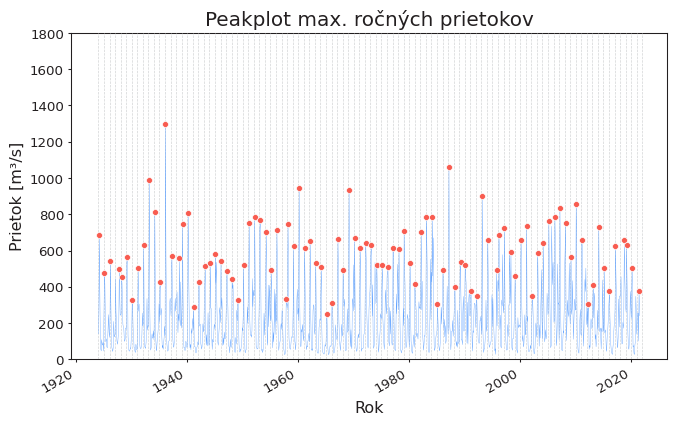

In [19]:
plot = model.plot_extremes()
plot[1].set_ylabel("Prietok [m³/s]", fontsize = 12)
plot[1].set_xlabel("Rok", fontsize = 12)
plot[1].set_ylim(0, 1800)
plot[1].set_title('Peakplot max. ročných prietokov', fontsize = 15)
plt.show()

## 3 Modely
V tejto sekcii sa pokusíme nájsť vhodný model pre naše dáta a vyriešiť úlohy zadané v úvode. Z tohto dôvodu si najprv vyčíslime hodnoty zadaných konštánt. Tieto možno vidieť v tabuľke nižšie.

In [20]:
sorted_data = annual_max.sort_values(by='discharge')

C = (sorted_data.iloc[int(sorted_data.shape[0] * 3 / 4)].values[1] + sorted_data.iloc[int(sorted_data.shape[0] * 3/ 4)+1].values[1]) / 2
D = sorted_data.iloc[-1].values[1] + 100
E = (sorted_data.iloc[4].values[1] + sorted_data.iloc[5].values[1]) / 2
Z = (sorted_data.iloc[-1].values[1] - sorted_data.iloc[int(sorted_data.shape[0] * 3 / 4)].values[1]) / 2
max_ = sorted_data.iloc[-1].values[1]


consts = pd.DataFrame(index = ['Hodnota'], columns = ['C', 'D', 'E', 'Z', 'max(x)', 'Z+C'], data=[[C, D, E, Z, max_, Z+C]])

styled_consts = consts.style.set_caption("Prehľad použitých konštánt").set_table_styles(styles)
styled_consts


,C,D,E,Z,max(x),Z+C
Hodnota,709.522000,1396.307000,320.235000,294.116000,1296.307000,1003.638000


In [21]:
def chernoff(data, eps):
    pass
def markov(data, eps):
    return np.mean(data) / eps
def chebyshev(data, eps):
    pass
def chebyshev_cantelli(data, eps):
    return np.var(data) / (np.var(data) + np.power(eps-np.mean(data), 2))

### 3.1 Distribution free nerovnosti
Takéto nerovnosti nám umožňujú relatívne spoľahlivo odhadnúť chvostové pravdepodobnosti javov pre ktoré máme len málo dát. Samozrejme platí, že dané odhady sú spoľahlivé za predpokladu existencie istých momentov čo ale často nemusí byť splnené a preto prinášajú relatívne hrubý odhad pradepodobností.

V tabuľke nižšie vidíme odhady pravdepodobností z úloh 1., 2. a 5. Čebyšev-Cantelliho nerovnosť priniesla zjavne najlepší odhad chvostovej pravdepodobností daných javov. Taktiež nastal pokus odhadnúť pravdepodobnosti pomocou Chernoffovskej metódy ale kvôli extrémne vysokým dosahovaným hodnotám nebolo možné numericky minimalizovať hodnotu daného odhadu.

In [22]:
vals = [[markov(annual_max['discharge'].to_numpy(), eps=C),
        chebyshev_cantelli(annual_max['discharge'].to_numpy(), eps=C)],
       [markov(annual_max['discharge'].to_numpy(), eps=D), 
        chebyshev_cantelli(annual_max['discharge'].to_numpy(), eps=D)],
        [markov(annual_max['discharge'].to_numpy(), eps=max_), 
        chebyshev_cantelli(annual_max['discharge'].to_numpy(), eps=max_)]
       ]
inequalities = pd.DataFrame(index = ['Úloha 1.:P(X>C) <=', 'Úloha 2.:P(X>D) <=', 'Úloha 5.:P(X>max(x)) <='], columns=['Markov', 'Čebyšev-Cantelli'],
                           data=vals)
styled_ineq = inequalities.style.set_caption("Odhady pomocou nerovností").set_table_styles(styles)
styled_ineq

,Markov,Čebyšev-Cantelli
Úloha 1.:P(X>C) <=,0.841160,0.719824
Úloha 2.:P(X>D) <=,0.427429,0.048574
Úloha 5.:P(X>max(x)) <=,0.460401,0.062524


### 3.2 Neparametrické odhady

V tejto sekcii sa pokúsime priniesť odhady pravdepodobností pomocou neparametrických odhadov hustôt pravdepodobností a to pomocou histogramových odhadov a jadrových odhadov. Prietok je nezáporná veličina a preto aj
odhady hustôt pravdepodobností musia mať nezáporný support.

#### 3.2.1 Histogramové odhady

V prípade histogramových odhadov vieme, že najdôležitejším hyperparametrom je šírka binu resp. počet binov. Vzhľadom k IMSE metrike je vhodné voliť šírku binu ~ $n^{-\frac{1}{3}}$ Histogramové odhady sú taktiež citlivé na polohu začiatku a konca delenia. V tomto prípade sa ponúka riešenie v zmysle tzv. average shifted histogramu. Inými vylepšeniami sú napr. histogramy s rozdielne širokými binmi.

In [23]:
def integrate_hist(hist, a, b):
    if a>=b:
        return 0.
    "my function to integrate histogram"
    density, edges, _ = hist

    lower = np.where(edges <= a)[0]
    lower_ind = lower.max() if len(lower) else 0
    upper = np.where(edges >= b)[0]
    upper_ind = upper.min() if len(upper) else -1
    
    edges[lower_ind] = a if a >= edges.min() else edges.min()
    edges[upper_ind] = b if b <= edges.max() else edges.max()
    
    edges = edges[lower_ind:] if upper_ind == -1 else edges[lower_ind:upper_ind+1]
    dens = density[lower_ind:] if upper_ind == -1 else density[lower_ind:upper_ind]
    diffs = np.diff(edges)
    
    
    return diffs @ dens.T if len(diffs) else 0.
    
maxes = annual_max['discharge'].to_numpy()

# for details see https://numpy.org/doc/stable/reference/generated/numpy.histogram_bin_edges.html#numpy.histogram_bin_edges
# bins parameter alows to define different bin sizes

   Na nasledujúcich štyroch obrázkoch môžme vidieť histogramové odhady hustôt pravdepodobnosti. Modrý histogram bol vytvorený s použitím 20 binov. Zelený histogram bol vytvorený použitím Freedman–Diaconisovej metódy teda šírka binu bola rovná $h=\frac{2 IQR}{n^{\frac{1}{3}}} $. Fialový histogram vznikol použitím šírky binu vypočítanej pomocou krížovej validácie nad IMSE. Posledný, žltý histogram vznikol takpovediac od oka vhodným nastavením šírky jednotlivých binov. Žltý histogram podľa mňa najlepšie popisuje dáta ale len pohľadovo nie je jasné o aké rozdelenie by mohlo ísť.

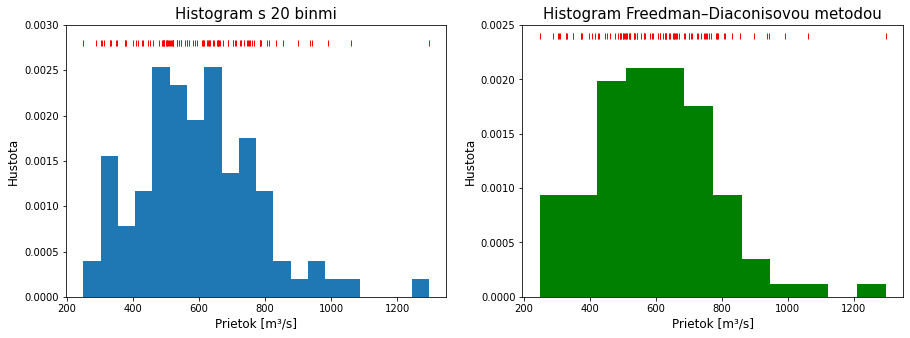

In [24]:
# 20 bins
fig, ax = plt.subplots(1, 2, figsize=(15,5))
hist1 = ax[0].hist(maxes, bins=20, density=True)
ax[0].plot(maxes, [0.0028]*len(maxes), '|', color='red')
ax[0].set_ylim(0., 0.003)
ax[0].set_title('Histogram s 20 binmi', fontsize = 15)
ax[0].set_xlabel('Prietok [m³/s]', fontsize = 12)
ax[0].set_ylabel('Hustota', fontsize = 12)

# diaconis method
hist2 = ax[1].hist(maxes, bins='fd', density=True, color='green')
ax[1].plot(maxes, [0.0024]*len(maxes), '|', color='red')
ax[1].set_ylim(0., 0.0025)
ax[1].set_title('Histogram Freedman–Diaconisovou metodou', fontsize = 15)
ax[1].set_xlabel('Prietok [m³/s]', fontsize = 12)
ax[1].set_ylabel('Hustota', fontsize = 12)

plt.show()
#print(integrate_hist(hist1, 0, np.inf))

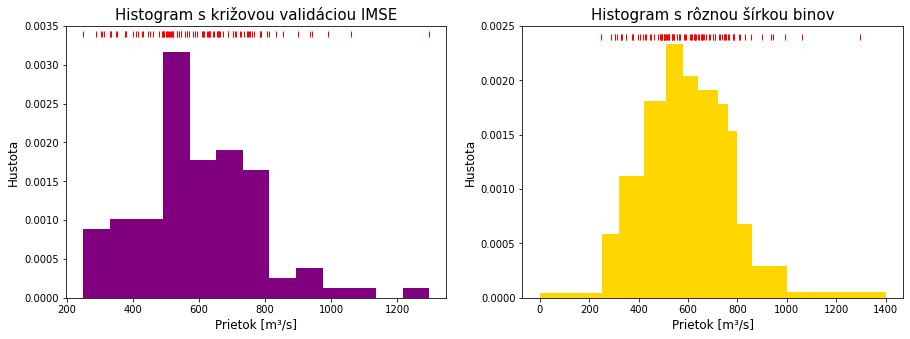

In [25]:
# using stone method  one-leave out cross-validation over IMSE
fig, ax = plt.subplots(1, 2, figsize=(15,5))
hist3 = ax[0].hist(maxes, bins='stone', density=True, color='purple')
ax[0].plot(maxes, [0.0034]*len(maxes), '|', color='red')
ax[0].set_ylim(0., 0.0035)
ax[0].set_title('Histogram s križovou validáciou IMSE', fontsize = 15)
ax[0].set_xlabel('Prietok [m³/s]', fontsize = 12)
ax[0].set_ylabel('Hustota', fontsize = 12)

# custom with different bin widths
edges = (0.,250., 320., 420., 510., 580.,  640.,  720., 760., 800.,
        860., 1000., 1400.)

hist4 = ax[1].hist(maxes, bins=edges, density=True, color='gold')
ax[1].plot(maxes, [0.0024]*len(maxes), '|', color='red')
ax[1].set_ylim(0., 0.0025)
ax[1].set_title('Histogram s rôznou šírkou binov', fontsize = 15)
ax[1].set_xlabel('Prietok [m³/s]', fontsize = 12)
ax[1].set_ylabel('Hustota', fontsize = 12)


plt.show()
#print(integrate_hist(hist1, 0, np.inf))

#### 3.2.2 Jadrové odhady

V prípade jadrových odhadov je známe, že medzi hlavné hyperparametre patria samotné jadro a šírka okna ktorá spôsobuje atomizáciu alebo vyhladenie odhadu. Optimálna voľba vzhľadom k IMSE je pri jadrových odhadoch  ~ $n^{-\frac{1}{5}}$. V našich odhadoch sme používali hodnoty šírky okna pomocou Scottovej metódy teda  $h=1.06min(std(x),\frac{IQR}{1.34})n^{\frac{1}{5}} $ a Silvermanovej metódy teda $h=9min(std(x),\frac{IQR}{1.34})n^{\frac{1}{5}} $ prípadne sme určili hodnotu šírky okna od oka. Skúšali sme postupne gaussovo, obdĺžnikové, trojuholníkové a epanachnikové jadro. Celkovo sme tak získali 8 jadrových odhadoch, ktoré sú zobrazené na nasledujúcich obrázkoch. Gaussovský jadrový odhad je pekne vyhladený. Odhad s použitím obdĺžnikového jadra je zjavne zubatý ale naznačuje možný bimodalálny charakter rozdelenia. Ostatné odhady sú veľmi podobné a taktiež naznačujú možný bimodálny charakter rozdelenia. 

In [26]:
# custom kde integrator using scipy's genereal purpose `quad` function 
def integrate_kde(kde, a, b):
    return quad(lambda x: 0. if isinstance(np.nan, type(kde.evaluate(x))) else kde.evaluate(x), a, b)[0] # second element is estimate of absolute error of integral

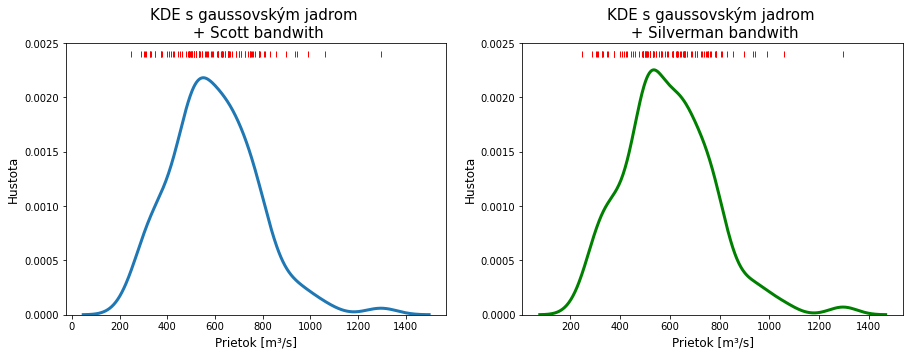

In [27]:
fig, ax = plt.subplots(1, 2, figsize=(15,5))

# gausian kernel
kde1 = KDEUnivariate(maxes)
kde1.fit(kernel='gau', bw='scott', clip=(0, np.inf))  # Estimate the densities on support (0, +inf)

ax[0].plot(kde1.support, kde1.density, lw=3, label="KDE from samples", zorder=10)
ax[0].plot(maxes, [0.0024]*len(maxes), '|', color='red')
ax[0].set_ylim(0., 0.0025)
ax[0].set_title('KDE s gaussovským jadrom \n + Scott bandwith', fontsize = 15)
ax[0].set_xlabel('Prietok [m³/s]', fontsize = 12)
ax[0].set_ylabel('Hustota', fontsize = 12)

kde2 = KDEUnivariate(maxes)
kde2.fit(kernel='gau', bw='silverman', clip=(0, np.inf))  # Estimate the densities on support (0, +inf)

ax[1].plot(kde2.support, kde2.density, lw=3, label="KDE from samples", zorder=10, color='green')
ax[1].plot(maxes, [0.0024]*len(maxes), '|', color='red')
ax[1].set_ylim(0., 0.0025)
ax[1].set_title('KDE s gaussovským jadrom \n + Silverman bandwith', fontsize = 15)
ax[1].set_xlabel('Prietok [m³/s]', fontsize = 12)
ax[1].set_ylabel('Hustota', fontsize = 12)

plt.show()

#integrate_kde(kde1, 0, 10000)

#https://stackabuse.com/kernel-density-estimation-in-python-using-scikit-learn/
#https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KernelDensity.html#sklearn.neighbors.KernelDensity
#https://www.statsmodels.org/dev/examples/notebooks/generated/kernel_density.html#The-KDE-is-a-distribution

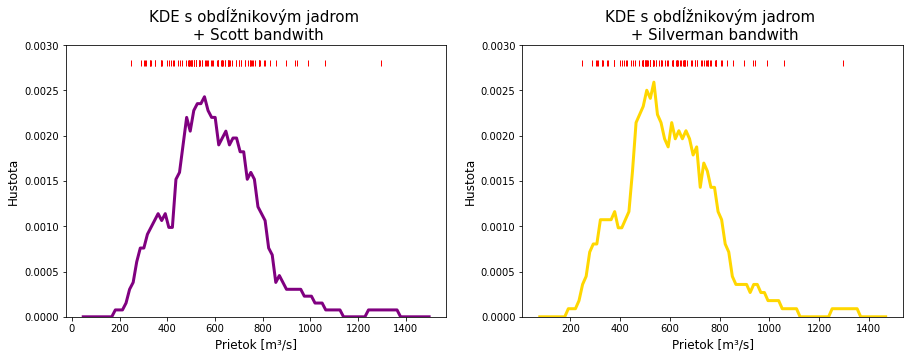

In [28]:
fig, ax = plt.subplots(1, 2, figsize=(15,5))

# rectangular kernel
kde3 = KDEUnivariate(maxes)
kde3.fit(kernel='uni', bw='scott', clip=(0, np.inf), fft=False)  # Estimate the densities on support (0, +inf)

ax[0].plot(kde3.support, kde3.density, lw=3, label="KDE from samples", zorder=10, color='purple')
ax[0].plot(maxes, [0.0028]*len(maxes), '|', color='red')
ax[0].set_ylim(0., 0.0030)
ax[0].set_title('KDE s obdĺžnikovým jadrom \n + Scott bandwith', fontsize = 15)
ax[0].set_xlabel('Prietok [m³/s]', fontsize = 12)
ax[0].set_ylabel('Hustota', fontsize = 12)

kde3 = KDEUnivariate(maxes)
kde3.fit(kernel='uni', bw='silverman', clip=(0, np.inf), fft=False)  # Estimate the densities on support (0, +inf)

ax[1].plot(kde3.support, kde3.density, lw=3, label="KDE from samples", zorder=10, color='gold')
ax[1].plot(maxes, [0.0028]*len(maxes), '|', color='red')
ax[1].set_ylim(0., 0.0030)
ax[1].set_title('KDE s obdĺžnikovým jadrom \n + Silverman bandwith', fontsize = 15)
ax[1].set_xlabel('Prietok [m³/s]', fontsize = 12)
ax[1].set_ylabel('Hustota', fontsize = 12)

plt.show()

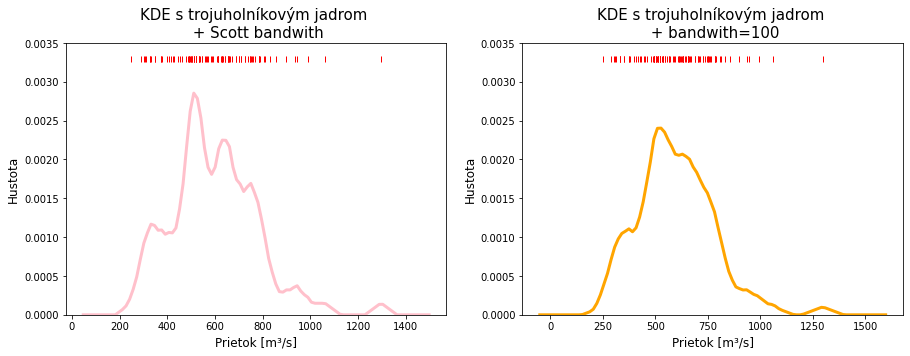

In [29]:
fig, ax = plt.subplots(1, 2, figsize=(15,5))

# triangular kernel
kde5 = KDEUnivariate(maxes)
kde5.fit(kernel='tri', bw='scott', clip=(0, np.inf), fft=False)  # Estimate the densities on support (0, +inf)

ax[0].plot(kde5.support, kde5.density, lw=3, label="KDE from samples", zorder=10, color='pink')
ax[0].plot(maxes, [0.0033]*len(maxes), '|', color='red')
ax[0].set_ylim(0., 0.0035)
ax[0].set_title('KDE s trojuholníkovým jadrom \n + Scott bandwith', fontsize = 15)
ax[0].set_xlabel('Prietok [m³/s]', fontsize = 12)
ax[0].set_ylabel('Hustota', fontsize = 12)

kde6 = KDEUnivariate(maxes)
kde6.fit(kernel='tri', bw=100, clip=(0, np.inf), fft=False)  # Estimate the densities on support (0, +inf)

ax[1].plot(kde6.support, kde6.density, lw=3, label="KDE from samples", zorder=10, color='orange')
ax[1].plot(maxes, [0.0033]*len(maxes), '|', color='red')
ax[1].set_ylim(0., 0.0035)
ax[1].set_title('KDE s trojuholníkovým jadrom \n + bandwith=100', fontsize = 15)
ax[1].set_xlabel('Prietok [m³/s]', fontsize = 12)
ax[1].set_ylabel('Hustota', fontsize = 12)

plt.show()

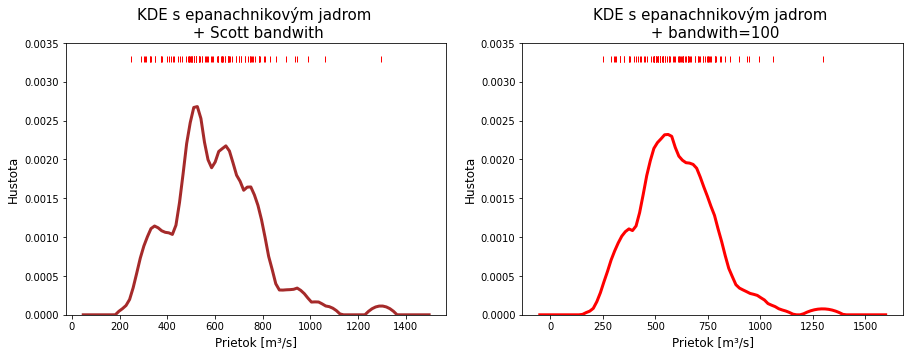

In [30]:
fig, ax = plt.subplots(1, 2, figsize=(15,5))

# epanachnikov kernel
kde7 = KDEUnivariate(maxes)
kde7.fit(kernel='epa', bw='scott', clip=(0, np.inf), fft=False)  # Estimate the densities on support (0, +inf)

ax[0].plot(kde7.support, kde7.density, lw=3, label="KDE from samples", zorder=10, color='brown')
ax[0].plot(maxes, [0.0033]*len(maxes), '|', color='red')
ax[0].set_ylim(0., 0.0035)
ax[0].set_title('KDE s epanachnikovým jadrom \n + Scott bandwith', fontsize = 15)
ax[0].set_xlabel('Prietok [m³/s]', fontsize = 12)
ax[0].set_ylabel('Hustota', fontsize = 12)

kde8 = KDEUnivariate(maxes)
kde8.fit(kernel='epa', bw=100, clip=(0, np.inf), fft=False)  # Estimate the densities on support (0, +inf)

ax[1].plot(kde8.support, kde8.density, lw=3, label="KDE from samples", zorder=10, color='red')
ax[1].plot(maxes, [0.0033]*len(maxes), '|', color='red')
ax[1].set_ylim(0., 0.0035)
ax[1].set_title('KDE s epanachnikovým jadrom \n + bandwith=100', fontsize = 15)
ax[1].set_xlabel('Prietok [m³/s]', fontsize = 12)
ax[1].set_ylabel('Hustota', fontsize = 12)

plt.show()


Nakoľko nám histogramy a jadrové odhady prinášajú regulárny odhad hustôt pravdepodobností môžme pomocou nich vyčísliť všetky požadované pravdepodobnosti resp. kvantily daných rozdelení ako je vyžadované v úlohe 4. Prehľad hodnôt pravdepodobností resp. minimálnej hranice je zobrazený v tabuľke nižšie. Odhady prinášajú veľmi podobné výsledky. Výnimkou je vlastný histogramový odhad s rôznou šírkou binov. Zrejme som  nastavil príliš tažký chvost a preto vychádzali výrazne vyššie hodnoty odhadov pravdepodobností.

In [31]:
cdf_h2 = np.cumsum(hist2[0]*np.diff(hist2[1]))
cdf_h4 = np.cumsum(hist4[0]*np.diff(hist4[1]))
cdf_k2 = np.cumsum(kde2.density[:-1]*np.diff(kde2.support))
cdf_k6 = np.cumsum(kde6.density[:-1]*np.diff(kde6.support))
cdf_k7 = np.cumsum(kde7.density[:-1]*np.diff(kde7.support))
cdf_k8 = np.cumsum(kde8.density[:-1]*np.diff(kde8.support))

vals = [[integrate_hist(hist2, C, np.inf), integrate_hist(hist4, C, np.inf), integrate_kde(kde2, C, np.inf), integrate_kde(kde6, C, np.inf), integrate_kde(kde7, C, np.inf), integrate_kde(kde8, C, np.inf)],
        [integrate_hist(hist2, D, np.inf), integrate_hist(hist4, D, np.inf), integrate_kde(kde2, D, np.inf), integrate_kde(kde6, D, np.inf), integrate_kde(kde7, D, np.inf), integrate_kde(kde8, D, np.inf)],
        [integrate_hist(hist2, 0, E), integrate_hist(hist4, 0, E), integrate_kde(kde2, 0, E), integrate_kde(kde6, 0, E), integrate_kde(kde7, 0, E), integrate_kde(kde8, 0, E)],
        [integrate_hist(hist2, max_, np.inf), integrate_hist(hist4, max_, np.inf), integrate_kde(kde2, max_, np.inf), integrate_kde(kde6, max_, np.inf), integrate_kde(kde7, max_, np.inf), integrate_kde(kde8, max_, np.inf)],
        [integrate_hist(hist2, Z + C, np.inf) / integrate_hist(hist2, C, np.inf), integrate_hist(hist4, Z + C, np.inf) / integrate_hist(hist4, C, np.inf),
         integrate_kde(kde2, Z + C, np.inf) / integrate_kde(kde2, C, np.inf), integrate_kde(kde6, Z + C, np.inf) / integrate_kde(kde6, C, np.inf),
         integrate_kde(kde7, Z + C, np.inf) / integrate_kde(kde7, C, np.inf), integrate_kde(kde8, Z + C, np.inf) / integrate_kde(kde8, C, np.inf)]
       ]
for p in (0.1, 0.04, 0.02, 0.01, 0.004):
    h_s = [hist2[1][np.min(np.where(cdf_h2 > 1-p))+1], hist4[1][np.min(np.where(cdf_h4 > 1-p))+1],
           kde2.support[np.min(np.where(cdf_k2 > 1-p))+1], kde6.support[np.min(np.where(cdf_k6 > 1-p))+1],
          kde7.support[np.min(np.where(cdf_k7 > 1-p))+1], kde8.support[np.min(np.where(cdf_k8 > 1-p))+1]]
    vals.append(h_s)

hists = pd.DataFrame(index = ['Úloha 1.:P(X>C) =', 'Úloha 2.:P(X>D) =', 
                              'Úloha 3.:P(X< E) =', 
                              'Úloha 5.:P(X>max(x)) =', 'Úloha 7.:P(X>Z+C|X>C) =',
                              'Úloha 4.:h(10-rocna) =', 'Úloha 4.:h(25-rocna) =', 'Úloha 4.:h(50-rocna) =',
                              'Úloha 4.:h(100-rocna) =', 'Úloha 4.:h(250-rocna) ='
                              ],
                     columns=['Hist-Diaconis', 'Hist-vlastný', 'Kern-Gauss-Silverman', 'Kern-Triang-100', 'Kern-Epanach-Scott', 'Kern-Epanach-100'],
                           data=vals)
styled_hists = hists.style.set_caption("Neparametrické odhady").set_table_styles(styles)
styled_hists

,Hist-Diaconis,Hist-vlastný,Kern-Gauss-Silverman,Kern-Triang-100,Kern-Epanach-Scott,Kern-Epanach-100
Úloha 1.:P(X>C) =,0.253620,0.254741,0.254591,0.250355,0.247836,0.250899
Úloha 2.:P(X>D) =,0.000000,0.000188,0.000408,0.000000,0.000000,0.000000
Úloha 3.:P(X< E) =,0.066589,0.051284,0.062060,0.057574,0.054988,0.058634
Úloha 5.:P(X>max(x)) =,0.011692,0.029343,0.005102,0.005102,0.005102,0.005102
Úloha 7.:P(X>Z+C|X>C) =,0.095057,0.329717,0.102573,0.098807,0.097058,0.100138
Úloha 4.:h(10-rocna) =,859.948250,1296.307000,828.441656,832.113753,825.018013,832.113753
Úloha 4.:h(25-rocna) =,1003.638000,1396.307000,950.852973,967.970330,959.610474,967.970330
Úloha 4.:h(50-rocna) =,1121.763500,1400.000000,1040.621272,1052.880691,1049.338782,1052.880691
Úloha 4.:h(100-rocna) =,1396.307000,1400.000000,1192.955355,1222.701412,1258.704833,1239.683485
Úloha 4.:h(250-rocna) =,1396.307000,1400.000000,1315.366672,1324.593845,1318.523704,1324.593845


### 3.4 Paramterické odhady

V tejto časti sa pokúsime najprv zhodnotiť vhodnosť niekoľkých paramterických modelov pomocou Q-Q plotov a následne vhodných kandidátov nafitovať na naše dáta pre ďalšiu analýzu. Nakoľko sú predmetom našej analýzy extremálne udalosti tak nás najviac zaujíma vhodnosť fitu v chvostovej časti rozdelení, špecificky nám ide o maximálne prietoky takže sa budeme sústrediť na pravé chvosty nasledujúcich rozdelení. Na obrázkoch nižšie môžme vidieť sériu štandardizovaných QQ-plotov pre rôzne rozdelenia. Z viacerých grafov sa zdá, že v dátach máme jeden outlier ale práve toto pozorovanie je za predpokladu jeho korektnosti to najpodstatnejšie ktoré máme. Ak vezmeme do úvahy vhodnosť fitu tak za najlepšieho kandidáta na parametricku rodinu je podľa QQ-plotu Log-logistické rozdelenie (Fiskovo), ktoré perfektne sedí v tele ako aj v pravom chvoste. Ďalším vhodným kandidátom na rodinu rozdelenia je inverzné gaussovo rozdelenie, ktoré tiež veľmi vierohodne popisuje naše dáta a to aj v pravom chvoste. Podobne sú na tom aj Rayleighovo a (vpravo zošikmené) Gumbelovo rozdelenie. Ďalej podľa QQ-plotu je GPD rozdelenie vhodné na popis našich dát zároveň stojí za povšimnutie, že QQ-plot GPD je veľmi podobný s QQ-plotom exponenciálneho rozdelenia čo naznačuje, že GPD rozdelenie ma shape parameter rovný nule. GEVD rozdelenie zjavne nepopisuje dáta dobre v tele ale najextrémnejšie pozorovanie popísalo správne a preto ho zatiaľ nevylučujem z ďalšej analýzy.

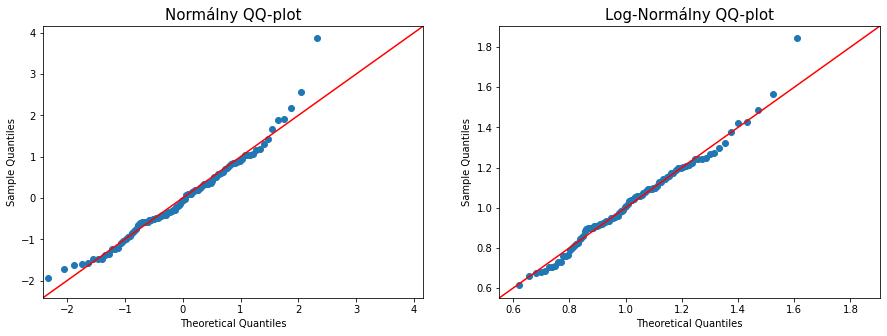

In [32]:
# https://docs.scipy.org/doc/scipy/reference/stats.html
# https://www.statsmodels.org/dev/generated/statsmodels.graphics.gofplots.qqplot.html

# !! QQ plots are standardized !!
   
fig, ax = plt.subplots(1, 2, figsize=(15,5))
qq_normal = sm.qqplot(maxes, stats.norm, fit=True, line="45", ax=ax[0])
ax[0].set_title('Normálny QQ-plot', fontsize = 15)
qq_lognormal = sm.qqplot(maxes, stats.lognorm, fit=True, line="45", ax=ax[1])
ax[1].set_title('Log-Normálny QQ-plot', fontsize = 15)
plt.show()

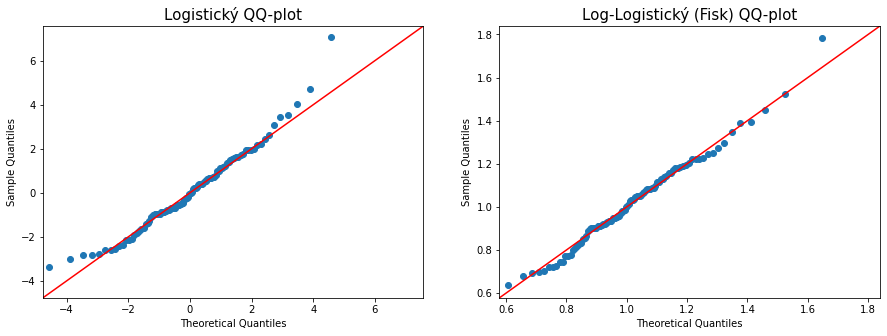

In [33]:
fig, ax = plt.subplots(1, 2, figsize=(15,5))
qq_logistic = sm.qqplot(maxes, stats.logistic, fit=True, line="45", ax=ax[0])
ax[0].set_title('Logistický QQ-plot', fontsize = 15)
qq_loglogistic = sm.qqplot(maxes, stats.fisk, fit=True, line="45", ax=ax[1])
ax[1].set_title('Log-Logistický (Fisk) QQ-plot', fontsize = 15)
plt.show()

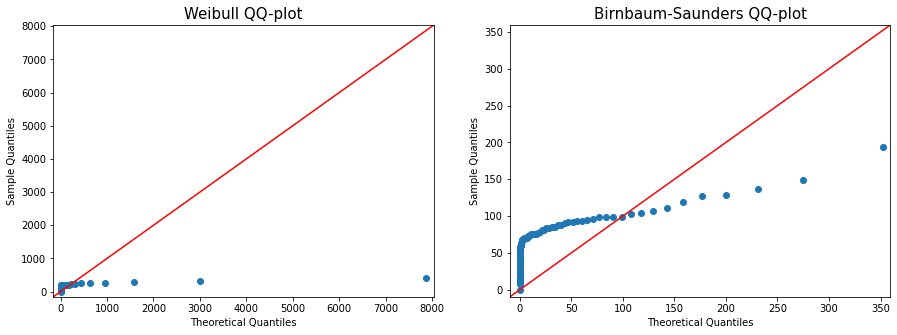

In [34]:
fig, ax = plt.subplots(1, 2, figsize=(15,5))
qq_weibull = sm.qqplot(maxes, stats.weibull_min, fit=True, line="45", ax=ax[0])
ax[0].set_title('Weibull QQ-plot', fontsize = 15)
qq_birnbaum = sm.qqplot(maxes, stats.fatiguelife, fit=True, line="45", ax=ax[1])
ax[1].set_title('Birnbaum-Saunders QQ-plot', fontsize = 15)
plt.show()

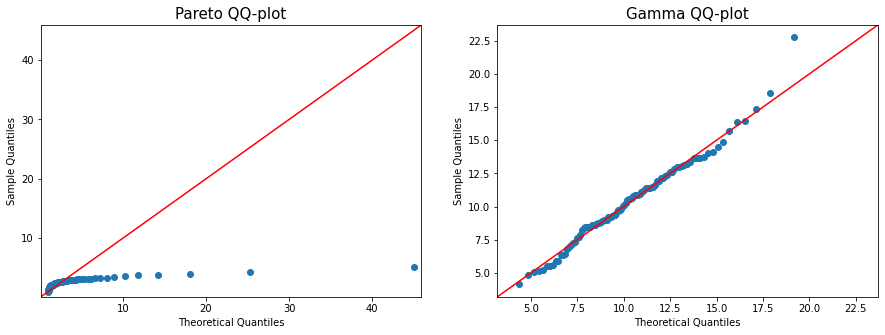

In [35]:
fig, ax = plt.subplots(1, 2, figsize=(15,5))
qq_pareto = sm.qqplot(maxes, stats.pareto, fit=True, line="45", ax=ax[0])
ax[0].set_title('Pareto QQ-plot', fontsize = 15)
qq_gamma = sm.qqplot(maxes, stats.gamma, fit=True, line="45", ax=ax[1])
ax[1].set_title('Gamma QQ-plot', fontsize = 15)
plt.show()

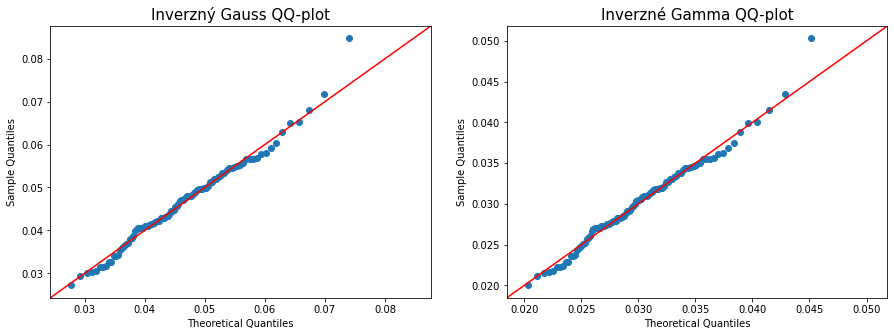

In [36]:
fig, ax = plt.subplots(1, 2, figsize=(15,5))
qq_invgauss = sm.qqplot(maxes, stats.invgauss, fit=True, line="45", ax=ax[0])
ax[0].set_title('Inverzný Gauss QQ-plot', fontsize = 15)
qq_invgamma = sm.qqplot(maxes, stats.invgamma, fit=True, line="45", ax=ax[1])
ax[1].set_title('Inverzné Gamma QQ-plot', fontsize = 15)
plt.show()

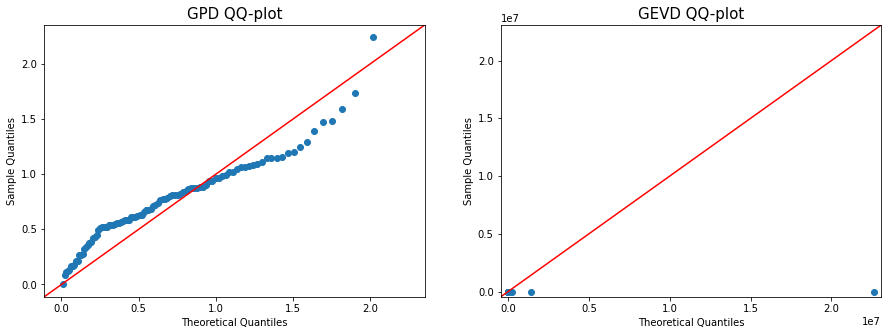

In [37]:
fig, ax = plt.subplots(1, 2, figsize=(15,5))
qq_gpd = sm.qqplot(maxes, stats.genpareto, fit=True, line="45", ax=ax[0])
ax[0].set_title('GPD QQ-plot', fontsize = 15)
qq_gev = sm.qqplot(maxes, stats.genextreme, fit=True,  line="45", ax=ax[1])
ax[1].set_title('GEVD QQ-plot', fontsize = 15)
plt.show()

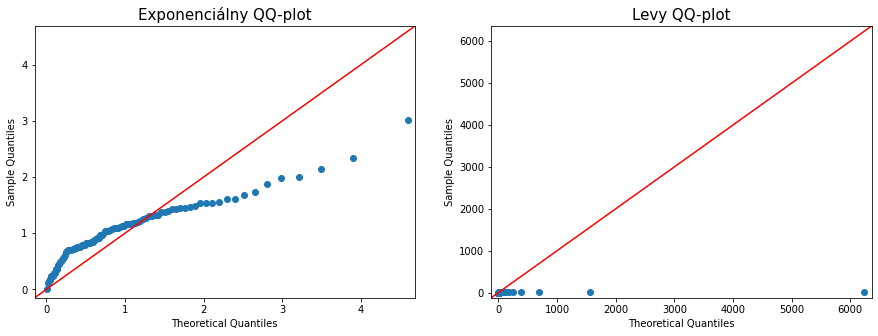

In [38]:
fig, ax = plt.subplots(1, 2, figsize=(15,5))
qq_exp = sm.qqplot(maxes, stats.expon, fit=True, line="45", ax=ax[0])
ax[0].set_title('Exponenciálny QQ-plot', fontsize = 15)
qq_elvy = sm.qqplot(maxes, stats.levy, fit=True,  line="45", ax=ax[1])
ax[1].set_title('Levy QQ-plot', fontsize = 15)
plt.show()

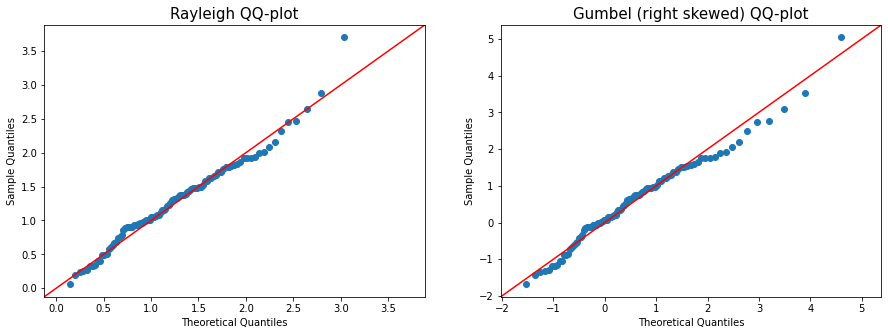

In [39]:
fig, ax = plt.subplots(1, 2, figsize=(15,5))
qq_ray= sm.qqplot(maxes, stats.rayleigh, fit=True, line="45", ax=ax[0])
ax[0].set_title('Rayleigh QQ-plot', fontsize = 15)
qq_gumbel = sm.qqplot(maxes, stats.gumbel_r, fit=True,  line="45", ax=ax[1])
ax[1].set_title('Gumbel (right skewed) QQ-plot', fontsize = 15)
plt.show()

Nakoľko sme na začiatku tohto protokolu používali odhady strednej hodnoty a rozptylu na kvantifikáciu horného odhadu istých pravdepodobností, tak nie je na škodu skúsiť zistiť či tieto odhady boli vôbec oprávnené t.j. či vôbec skutočná distribúcia má strednú hodnotu a rozptyl. Pre tento účel použijeme tzv. mean excess plot tiež známy ako mean residual life plot, ktorý nám pomôže určiť typ chvostu. Na obrázku nižšie môže vidieť spomínaný mean excess plot pre naše dáta. Na prvý pohľad je zrejme, že krivka nie je podobná priamke čo je očakávaný trend pre GPD distribúciu. Ja by som daný graf popísal skôr konštantou čo je typické pre exponenciálne chvosty resp. GPD distribúciu s shape parametrom rovným 0. Takýto záver je určite v zhode aj s pozorovaniami z QQ-plotov.

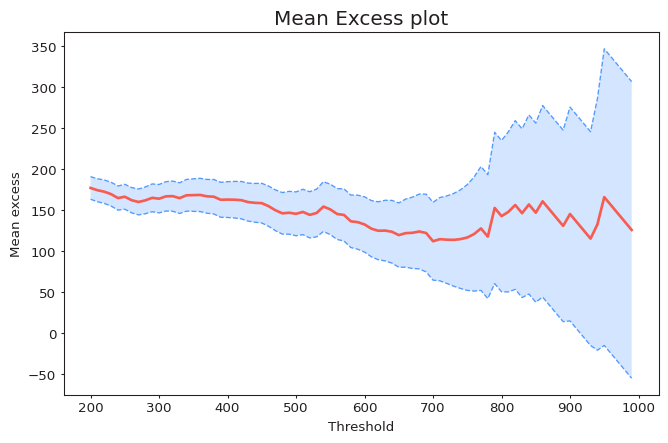

In [98]:
# mean excess plots aka mean reasidual life plots for detecting heavy tails (GPD)
me = plot_mean_residual_life(series, thresholds=[i for i in range(200, 1000, 10)])
me.set_title('Mean Excess plot', fontsize=15)
plt.show()

                           Univariate Extreme Value Analysis                            
                                      Source Data                                       
----------------------------------------------------------------------------------------
Data label:                     discharge      Size:                               1,171
Start:                      February 1924      End:                          August 2021
                                     Extreme Values                                     
----------------------------------------------------------------------------------------
Count:                                 98      Extraction method:                     BM
Type:                                high      Block size:             365 days 05:49:12
                                         Model                                          
----------------------------------------------------------------------------------------
Model:               

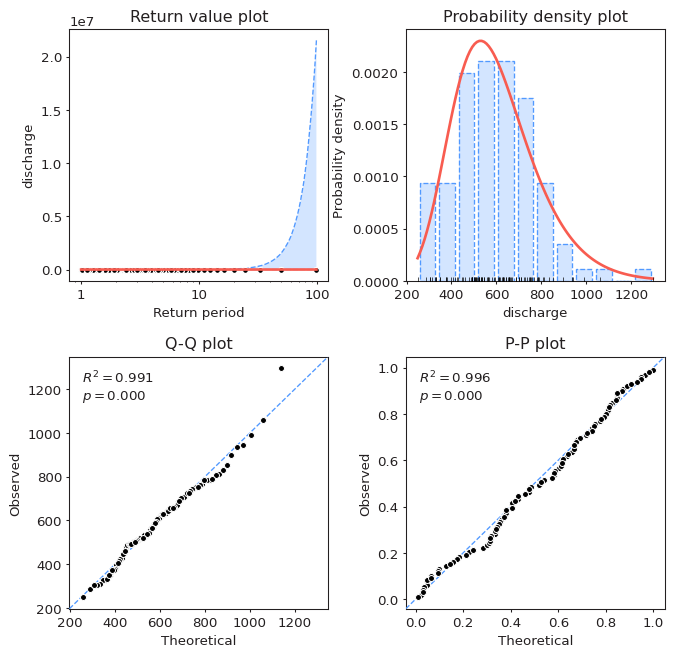

In [41]:
# we already have general EVA model
# GEV model

model.fit_model(model = "Emcee", # also "Emcee" - Markov Chain Monte Carlo (MCMC) model. is supported
                distribution = stats.genextreme,
                distribution_kwargs = None)
print(model)
model.plot_diagnostic(alpha=0.95)
gev_cdf = model.model.cdf
gev_isf = model.model.isf
plt.show()

                           Univariate Extreme Value Analysis                            
                                      Source Data                                       
----------------------------------------------------------------------------------------
Data label:                     discharge      Size:                               1,171
Start:                      February 1924      End:                          August 2021
                                     Extreme Values                                     
----------------------------------------------------------------------------------------
Count:                                 98      Extraction method:                     BM
Type:                                high      Block size:             365 days 05:49:12
                                         Model                                          
----------------------------------------------------------------------------------------
Model:               

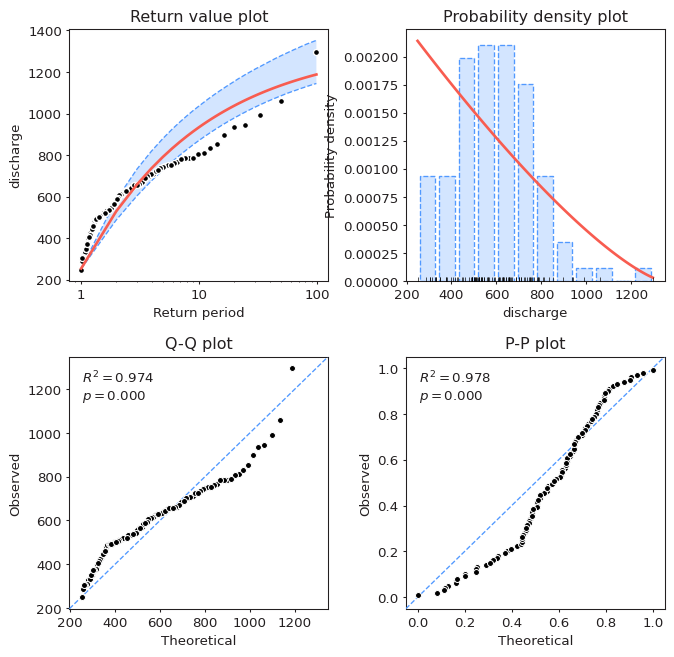

In [42]:
# GPD
model.fit_model(model = "Emcee", # also "Emcee" - Markov Chain Monte Carlo (MCMC) model. is supported
                distribution = stats.genpareto,
                distribution_kwargs = None)
print(model)
model.plot_diagnostic(alpha=0.95)
gpd_cdf = model.model.cdf
gpd_isf = model.model.isf
plt.show()

                           Univariate Extreme Value Analysis                            
                                      Source Data                                       
----------------------------------------------------------------------------------------
Data label:                     discharge      Size:                               1,171
Start:                      February 1924      End:                          August 2021
                                     Extreme Values                                     
----------------------------------------------------------------------------------------
Count:                                 98      Extraction method:                     BM
Type:                                high      Block size:             365 days 05:49:12
                                         Model                                          
----------------------------------------------------------------------------------------
Model:               

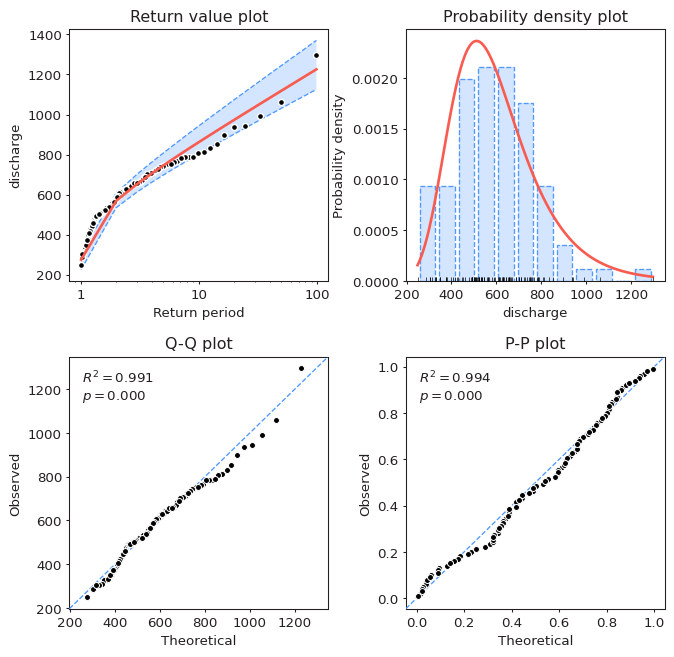

In [43]:
# Gumbel right skewed
model.fit_model(model = "Emcee", # also "Emcee" - Markov Chain Monte Carlo (MCMC) model. is supported
                distribution = stats.gumbel_r,
                distribution_kwargs = None)
print(model)
model.plot_diagnostic(alpha=0.95)
gumbel_cdf = model.model.cdf
gumbel_isf = model.model.isf
plt.show()

                           Univariate Extreme Value Analysis                            
                                      Source Data                                       
----------------------------------------------------------------------------------------
Data label:                     discharge      Size:                               1,171
Start:                      February 1924      End:                          August 2021
                                     Extreme Values                                     
----------------------------------------------------------------------------------------
Count:                                 98      Extraction method:                     BM
Type:                                high      Block size:             365 days 05:49:12
                                         Model                                          
----------------------------------------------------------------------------------------
Model:               

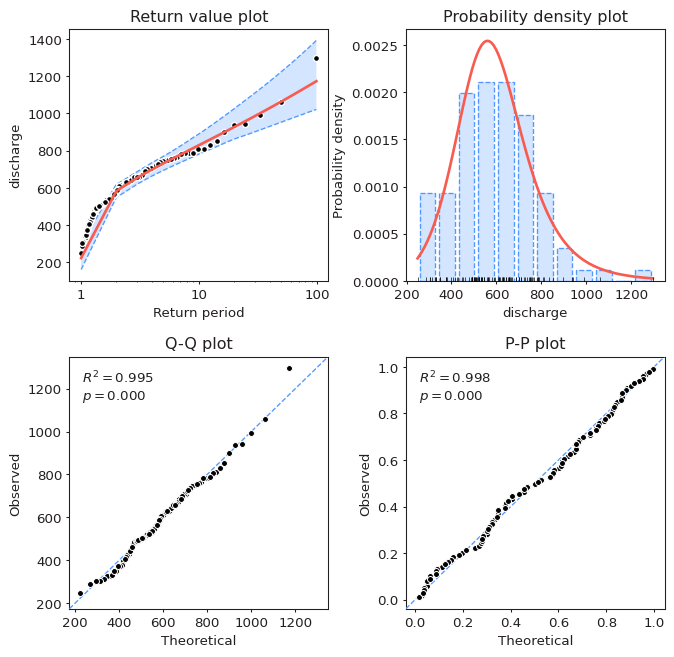

In [44]:
# Fisk
model.fit_model(model = "MLE", # also "Emcee" - Markov Chain Monte Carlo (MCMC) model. is supported
                distribution = stats.fisk,
                distribution_kwargs = None)
print(model)
model.plot_diagnostic(alpha=0.95)
fisk_cdf = model.model.cdf
fisk_isf = model.model.isf

plt.show()

In [45]:
summary = model.get_summary(
    return_period=[1, 2, 5, 10, 25, 50, 100, 250, 500, 1000],
    alpha=0.95,
    n_samples=1000)
#print(summary)  #  ----> another way to get return values 100-year flood etc.

In [46]:
vals2 = [[1-gpd_cdf(C), 1-gev_cdf(C), 1-gumbel_cdf(C), 1-fisk_cdf(C)],
       [1-gpd_cdf(D), 1-gev_cdf(D), 1-gumbel_cdf(D), 1-fisk_cdf(D)],
       [gpd_cdf(E), gev_cdf(E), gumbel_cdf(E), fisk_cdf(E)],
       [1-gpd_cdf(max_), 1-gev_cdf(max_), 1-gumbel_cdf(max_), 1-fisk_cdf(max_)],
       [(1-gpd_cdf(C + Z)) / (1-gpd_cdf(C)), (1-gev_cdf(C + Z)) / (1-gev_cdf(C)), (1-gumbel_cdf(C + Z)) / (1-gumbel_cdf(C)), (1-fisk_cdf(C+Z)) / (1-fisk_cdf(C))]]

for p in (0.1, 0.04, 0.02, 0.01, 0.004):
    h_s = [gpd_isf(p), gev_isf(p), gumbel_isf(p), fisk_isf(p)]
    vals2.append(h_s)

models = pd.DataFrame(index = ['Úloha 1.:P(X>C) =', 'Úloha 2.:P(X>D) =', 
                              'Úloha 3.:P(X< E) =', 
                              'Úloha 5.:P(X>max(x)) =', 'Úloha 7.:P(X>Z+C|X>C) =',
                              'Úloha 4.:h(10-rocna) =', 'Úloha 4.:h(25-rocna) =', 'Úloha 4.:h(50-rocna) =',
                              'Úloha 4.:h(100-rocna) =', 'Úloha 4.:h(250-rocna) ='
                              ],
                     columns=['GPD', 'GEV', 'Gumbel (right skewed)', 'Fisk'],
                           data=vals2)
styled_models = models.style.set_caption("Parametrické odhady").set_table_styles(styles)
styled_models

,GPD,GEV,Gumbel (right skewed),Fisk
Úloha 1.:P(X>C) =,0.278243,0.246984,0.244443,0.230964
Úloha 2.:P(X>D) =,0.000000,0.000818,0.003388,0.002858
Úloha 3.:P(X< E) =,0.145693,0.039946,0.032666,0.043301
Úloha 5.:P(X>max(x)) =,0.000567,0.002296,0.006433,0.004931
Úloha 7.:P(X>Z+C|X>C) =,0.231143,0.126232,0.169569,0.128484
Úloha 4.:h(10-rocna) =,933.495130,848.536403,861.765762,828.612087
Úloha 4.:h(25-rocna) =,1065.674711,972.075037,1009.294412,959.413192
Úloha 4.:h(50-rocna) =,1136.323634,1058.085230,1118.739591,1063.772467
Úloha 4.:h(100-rocna) =,1188.827833,1138.988666,1227.376645,1174.844887
Úloha 4.:h(250-rocna) =,1238.137224,1239.107888,1370.415084,1334.012201


### 3.5 POT model
Všetky úlohy sme v predchádzajúcom riešili štandardne pomocou tzv. `Block maxima` prístupu. Poslednú úlohu o prekročení zábrany skúsme vyriešiť `Peak over treshold` (POT) prístupom. V tejto mete je najdôležitejšie a zároveň najťažšie určiť vhodný threshold keďže na jeho voľbe závisí výsledok analýzy. Podľa vykresleného mean excess plotu sa zdá, že vhodné thresholdy su v intervale (350-700) nakoľko v tomto intervale je daný graf zhruba lineárny čo sa očakáva od GPD. Ďalej sme na odhad vhodného thresholdu použili graf stability parametrov. Tento graf je na obrázku nižšie a popisuje zmeny shape a scale parametrov GPD pri rôznych thresholdoch. Optimálna hodnota thresholdu by mala byť v intervale kde nedochádza k výrazným zmenám parametrov. Preto za vhodný threshold volíme hodnotu 350.

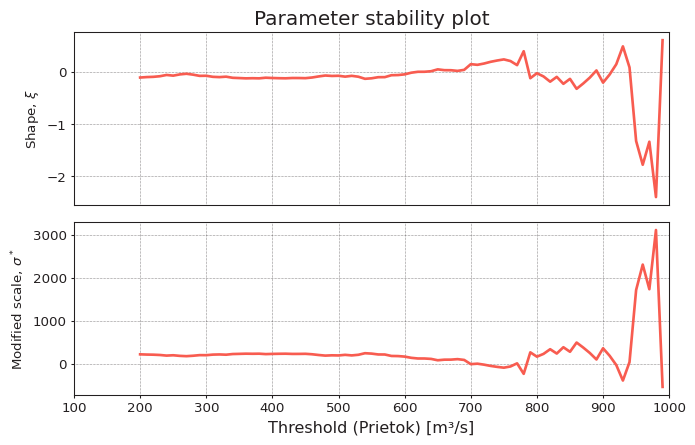

In [87]:

plot = plot_parameter_stability(series, thresholds=[i for i in range(200, 1000, 10)])
plot[1].set_xlabel("Threshold (Prietok) [m³/s]", fontsize = 12)
plot[0].set_title('Parameter stability plot', fontsize = 15)
plot[1].set_xlim(100, 1000)
plot[0].set_xlim(100, 1000)
plt.show()

Z teórie je známe, že rozdelenie POT extrémnych hodnôt konverguje k GPD distribúcii. Ak teda označíme náš threshold $u$ a náhodnú veličinu popisujúcu veľkosť prietoku $X$ a ďalej definujeme náhodnú veličinu $Y=X-u$ ako náš `peak over threshold` tak môžeme zaviesť tzv. excess distribuúciu ako
$$F_u(x)=P(X-u < x| X > u)$$ 
o ktorej predpokladáme, že sa riadi GPD distribúciou.
Ďalej z teórie vyplýva, že môžme odhadovať pravdepodobnosť $P(X>x)$ nasledovne:
$$P(X>x) = P(X>u)[1-F_u(x-u)]$$

Nižšie môžme vidieť výstup programu po nafitovaní POT modelu s thresholdom = 350. Z QQ-plotu ako aj PP-plotu sa zdá byť model vhodný a preto môžme odhadnúť potrebnú pravdepodobnosť z úlohy 7.:$$P(X>Z+C|X>C) = \frac{P(X>Z+C)}{  P(X>C)} = 0.1746$$

                           Univariate Extreme Value Analysis                            
                                      Source Data                                       
----------------------------------------------------------------------------------------
Data label:                     discharge      Size:                               1,171
Start:                      February 1924      End:                          August 2021
                                     Extreme Values                                     
----------------------------------------------------------------------------------------
Count:                                222      Extraction method:                    POT
Type:                                high      Threshold:                            350
                                         Model                                          
----------------------------------------------------------------------------------------
Model:               

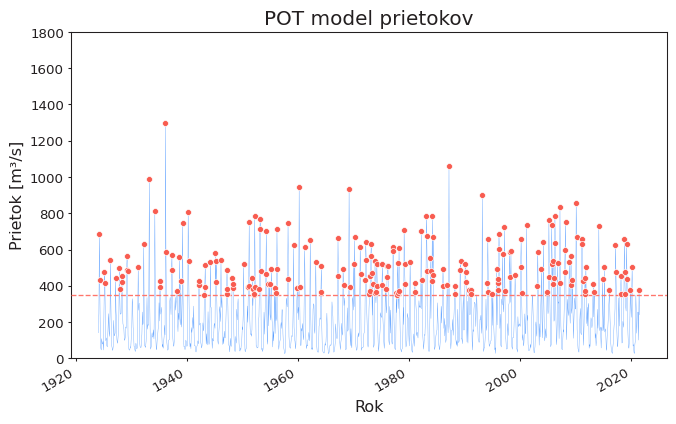

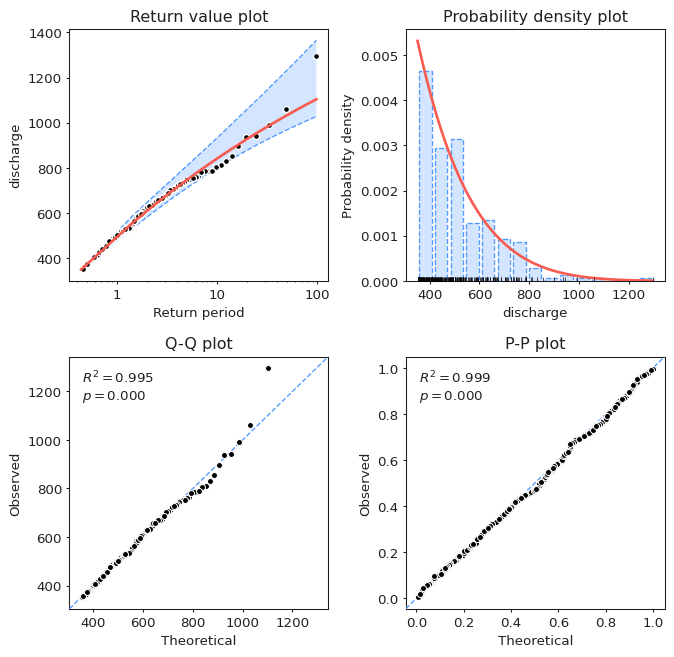

In [99]:
mod = EVA(series)
mod.get_extremes(method="POT", threshold=350, r="216H")
mod.fit_model(model = "Emcee", # also "Emcee" - Markov Chain Monte Carlo (MCMC) model. is supported
                distribution = stats.genpareto,
                distribution_kwargs = None)
print(mod)

plot = mod.plot_extremes()
plot[1].set_ylabel("Prietok [m³/s]", fontsize = 12)
plot[1].set_xlabel("Rok", fontsize = 12)
plot[1].set_ylim(0, 1800)
plot[1].set_title('POT model prietokov', fontsize = 15)

mod.plot_diagnostic(alpha=0.95)
plt.show()

In [101]:
# according to some theorem we can estimate peak over threshold tail distribution as ...
# actually it is distribution of X

tail_excess_cdf = lambda x: (mod.extremes.shape[0] / series.shape[0]) * (1 - mod.model.cdf(x-350))
#tail_excess_cdf(Z+C) / tail_excess_cdf(C)
#tail_excess_cdf(Z+C)
#tail_excess_cdf(C)


In [108]:
n_98 = np.arange(1 , 99)
n_148 = np.arange(1 , 149)
E_n = np.sum(1/n_148) - 3

### 3.6 Očakávaný počet rekordov za 50 rokov
Nakoniec ešte zodpovedajme otázku 6 ohľadom očakávaného počtu rekordov v nasledujúcich 50 rokoch. Vychádzať budeme z modelu využívajúceho ročné maximá. Ak označíme $E_n$ očakávaný počet rekordov v postupnosti $n$ sledovaných událostí tak platí  $$E_n = \sum_{i=1}^n{\frac{1}{i}}$$
Celkovo máme 98 pozorovaní pričom v nich nastal rekord celkovo 3-krát a preto očakávame, že ešte nastanú
$$E_{50} = E_{148} - 3 = 2.58$$ teda zhruba 2-3 rekordy za najbližších 50 rokov. 

## 4 Záver

V tomto protokole sme analyzovali prietoky rieky Marrimack a snažili sme sa kvantitatívne určiť hodnoty pravdepodobstí zadefinovaných v úvode. Analýzu sme vykonali pomocou tzv. `block maxima` prístupu resp. pomocou ročných maxím. Úlohu 7 sme sa následne snažili analyzovať aj pomocou `peak over threshold` prístupu. Tento POT prístup za ukázal byť významne závislý na hodnote thresholdu a taktiež sme uvažovali hodnoty $C$ a $Z$ na základe pozorovaní získaných block maxima prístupom. Model POT je zaujímavou alternatívou resp. doplňujúcim prístupom k BM metóde ale ako sme zistili vyžaduje výrazne viac ladenia a toto sme z časových dôvodov nestíhali. 
V prípade BM prístupu sme najprv vyskúšali odhady pomocou Markovej a Čebyšev-Canteliho nerovností. Ako sme očakávali tak tieto priniesli veľmi hrubé odhady. 
Ako neparametrické odhady sme vyskúšali histogramy s viacerými šírkami binov vrátane binov rôznej šírky. Taktiež sme skúšali jadrové odhady hustôt. Za njavhodnejšie neparametrické odhady považujem histogram s využitím Diaconisovej metódy na voľbu šírky binov a jadrový odhad pomocou epanachnikovho jadra. Tento záver sme nadobudli na základe ďalšej analýzy pomocou parametrických modelov a podľa oka najlepšej zhody z danými parametrickými modelmi. Po analýze QQ-plotov sme vybrali na parametrické modelovanie GPD, GEV, Gumbelovu a Fiskovu distribúciu nakoľko tieto najlešie sedeli na naše dáta. Ako sa ďalej ukázalo tak podľa AIC kritéria ako aj podľa už analyzovaných QQ-plotov boli GEV, Gumbelovo a Fiskovo rozdelenie najvhodnejšie a prinášali veľmi podobné odhady pravdepodobností. Taktiež sa ukázalo, že po nafitovaní GEV modelu bola hodnota shape parametru blízko nule a teda GEV a Gumbelovo rozdelenie boli takmer rovnaké. Taktiež je známe, že BM model by mal asymptoticky viesť na GEV distribúciu a aj preto by som za najvhodneší model vybral Gumbelovo alebo GEV rozdelenie.